In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from dem_stitcher.stitcher import stitch_dem
import rasterio
import matplotlib.pyplot as plt
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np

In [22]:
site = 'bay_area' # 'bay_area' or 'aleutian' or 'odessa'
dem_0 = 'srtm_v3'  # 'ned1' #'tdx_30'
dem_1 = '3dep' #'nasadem' # 'ned1'
ellipsoidal_hgt = True

In [23]:
if site == 'bay_area':
    bounds = [-121.5, 34.95, -120.2, 36.25]
elif site == 'aleutian':
    bounds = [-170, 51, -160, 56]
elif site == 'odessa':
    bounds = [-103, 31, -101.5, 33]    
else:
    raise ValueError('Site not valid')

# dem_0

In [28]:
%%time

dem_arr_0, dem_prof_0 = stitch_dem(bounds, 
                                   dem_0, 
                                   # More than 5 workers can cause timeout errors.
                                   max_workers=5,
                                   dst_ellipsoidal_height=ellipsoidal_hgt)
dem_prof_0

CPU times: user 3.44 s, sys: 989 ms, total: 4.43 s
Wall time: 1min 16s


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4680, 'height': 4680, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -121.50013888888888,
       0.0, -0.0002777777777777778, 36.25013888888889), 'tiled': False, 'interleave': 'band'}

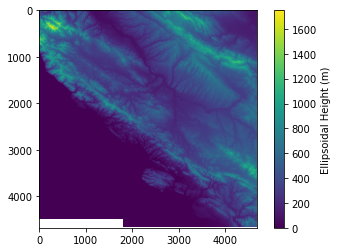

In [29]:
fig, ax = plt.subplots()
im = ax.imshow(dem_arr_0, vmin=0)
fig.colorbar(im, label='Ellipsoidal Height (m)')

# dem_1

In [30]:
%%time

dem_arr_1, dem_prof_1 = stitch_dem(bounds, 
                                   dem_1, 
                                   # More than 5 workers can cause timeout errors.
                                   max_workers=5,
                                   dst_ellipsoidal_height=ellipsoidal_hgt)
dem_prof_1

Reading 3dep Datasets: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


CPU times: user 4.97 s, sys: 1.26 s, total: 6.23 s
Wall time: 31.6 s


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 4681, 'height': 4681, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00027777770900043767, 0.0, -121.50014004788801,
       0.0, -0.00027777770900043767, 36.250140493105484), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

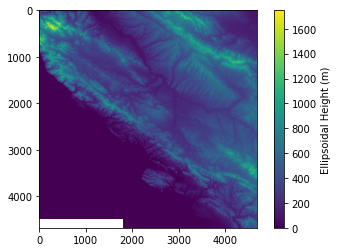

In [31]:
fig, ax = plt.subplots()
im = ax.imshow(dem_arr_1, vmin=0)
fig.colorbar(im, label='Ellipsoidal Height (m)')

# Comparison

In [32]:
X_1_r, _ = reproject_arr_to_match_profile(dem_arr_1, dem_prof_1, dem_prof_0)
X_1_r = X_1_r[0, ...]

In [33]:
# with rasterio.open(f'{site}_{dem_0}.tif','w', **dem_prof_0) as ds:
#     ds.write(dem_arr_0, 1)

In [34]:
# with rasterio.open(f'{site}_{dem_1}.tif','w', **dem_prof_0) as ds:
#     ds.write(X_1_r, 1)

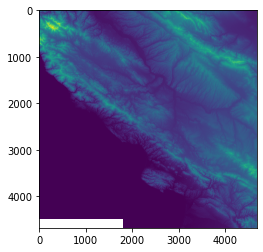

In [35]:
plt.imshow(X_1_r)

Text(0.5, 0, '3dep - srtm_v3 (m)')

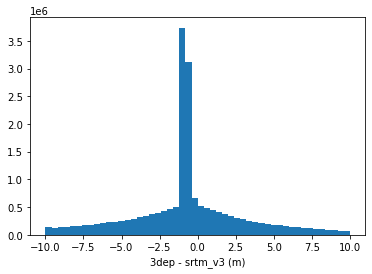

In [36]:
diff = (X_1_r - dem_arr_0)
diff_r = diff[~np.isnan(diff)]
plt.hist(diff_r, bins=50, range=(-10, 10))
plt.xlabel(f'{dem_1} - {dem_0} (m)')

In [37]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'diff': diff_r})
df['diff_cm'] = np.round(df['diff'] * 100, 3)
df.drop(columns=['diff'], inplace=True)
df.describe()

,diff_cm
count,2.157211e+07
mean,-1.546961e+02
std,6.479536e+02
min,-1.546561e+04
25%,-3.331813e+02
50%,-8.506200e+01
75%,7.604600e+01
max,8.997017e+03


In [38]:
T = 50
p = np.sum(np.abs(df.diff_cm) < 50) / df.shape[0]
print(f'percent less than {T} cm: {p*100:1.2f}%')
df[(np.abs(df.diff_cm) < T)].describe()

percent less than 50 cm: 8.19%


,diff_cm
count,1.767007e+06
mean,-1.092314e+01
std,3.097905e+01
min,-4.999900e+01
25%,-4.021300e+01
50%,-1.625400e+01
75%,1.568000e+01
max,4.999900e+01


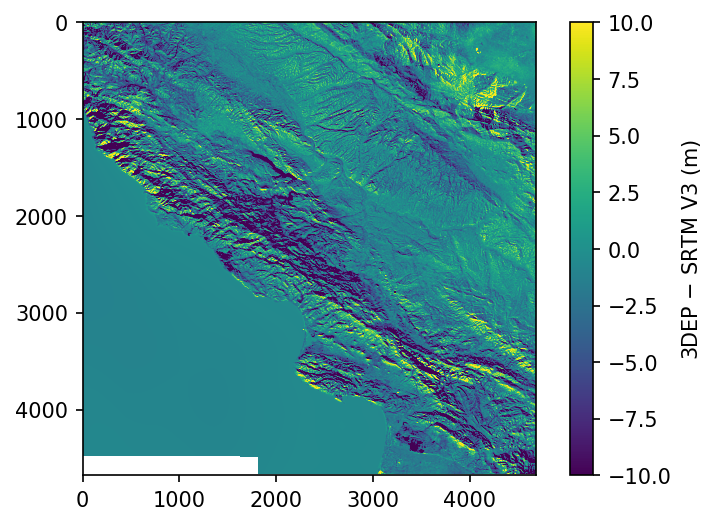

In [39]:
fig, ax = plt.subplots(dpi=150)
im = ax.imshow(diff, vmin=-10, vmax=10)
fig.colorbar(im, label=f'{dem_1.upper().replace("_", " ")} $-$ {dem_0.upper().replace("_", " ")} (m)')

In [40]:
# pp = dem_prof_0.copy()
# pp['driver'] = 'GTiff'
# with rasterio.open(f'{site}_diff_{dem_1}_m_{dem_0}.tif', 'w', **pp) as ds:
#     ds.write(diff.astype(np.float32), 1)